In [4]:
import sys
import os
sys.path.append("..")
from utils.train2 import *
device = 'cpu'

In [5]:
a = load_meta(os.path.join(os.pardir, 'metadata1'))

In [6]:
a.shape

(5902, 68)

In [15]:
class CustomAtenttion(nn.Module):
    def __init__(self, n_features, n_classes, layers_list, activation=nn.ReLU(), dropout_list=None, batch_norm=True):
        super(CustomAtenttion, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.layers_list = layers_list
        self.activation = activation
        self.dropout_list = dropout_list
        self.batch_norm = batch_norm
        self.net = []
        self.b_list = []
        if self.dropout_list:
            self.dropout_list = [nn.Dropout(i) for i in self.dropout_list]
        for i in range(len(self.layers_list)):
            if self.batch_norm:
                self.b_list.append(nn.BatchNorm1d(self.layers_list[i]))
            if i==0:
                self.net.append(nn.Linear(self.n_features, self.layers_list[i]))
            else:
                self.net.append(nn.Linear(self.layers_list[i-1]+3, self.layers_list[i]))
        self.last_layer = nn.Linear(self.layers_list[-1]+self.n_features-3, self.n_classes)
        self.net = nn.ModuleList(self.net)
        self.prev_atenttion = nn.Linear(self.n_features-3, 3*(self.n_features-3))
        self.atenttion = nn.MultiheadAttention(self.n_features-3, 64, batch_first=True)
    
    def forward(self, x):
        b_size, _ = x.size()
        vp = torch.clone(x[:,-3:])
        embx = torch.clone(x[:,:-3])
        embx = self.prev_atenttion(embx)
        qkv = embx.view(b_size, 3, -1)
        q, k, v = qkv.chunk(3, dim = 1)
        out, _ = self.atenttion(q, k, v)
        out = out.squeeze(dim=1)
        for i, l in enumerate(self.net):
            #print(i)
            if i==0:
                x = self.activation(l(x))
            else:
                x = self.activation(l(torch.cat((x, vp), dim=1)))
            if self.batch_norm:
                x = self.b_list[i](x)
            if self.dropout_list:
                x = (self.dropout_list[i])(x)
            
        x = self.last_layer(torch.cat((x, out), dim=1))
        if self.n_classes == 1:
            x = torch.sigmoid(x)
   
        return x

    def eval(self):
        self.train(False)
        for i in self.b_list:
            i.train(False)
    def cust_train(self):
        self.train(True)
        for i in self.b_list:
            i.train(True)

In [16]:
mod = CustomAtenttion(67, 788, [128, 128, 256, 256, 256], nn.GELU(), batch_norm=True)
print(mod)

CustomAtenttion(
  (activation): GELU()
  (last_layer): Linear(in_features=320, out_features=788, bias=True)
  (net): ModuleList(
    (0): Linear(in_features=67, out_features=128, bias=True)
    (1): Linear(in_features=131, out_features=128, bias=True)
    (2): Linear(in_features=131, out_features=256, bias=True)
    (3): Linear(in_features=259, out_features=256, bias=True)
    (4): Linear(in_features=259, out_features=256, bias=True)
  )
  (prev_atenttion): Linear(in_features=64, out_features=192, bias=True)
  (atenttion): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
)


In [17]:
eo = train(a, mod, ep=100, save=True, prefix = "atenttion")

C:\Users\LENOVO\.conda\envs\paltas\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
E:\belugas_classification\notebooks\..\utils\train2.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vec_train = np.array([train_ids for train_ids,_ in skf.split(data, data.iloc[:,-1])])
C:\Users\LENOVO\.conda\envs\paltas\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
E:\belugas_classification\notebooks\..\utils\train2.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tupl

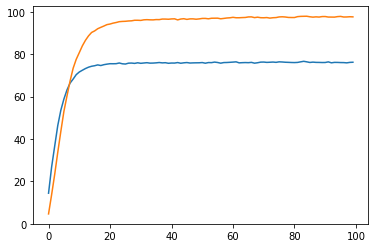

In [18]:
plt.plot(eo['acc'])
plt.plot(eo['train_acc'])

In [49]:
at = nn.MultiheadAttention(12, 4, batch_first=True)

In [50]:
m, w = at(torch.randn(1, 1, 12), torch.randn(1, 1, 12), torch.randn(1, 1, 12))

In [51]:
m

tensor([[[-0.0836, -0.7130,  0.3655, -0.0394,  0.2155, -0.2543,  0.7236,
           0.2701, -0.5202,  0.5084, -0.5707, -0.2636]]],
       grad_fn=<TransposeBackward0>)

In [66]:
m = nn.MultiheadAttention(2, 1, batch_first=True)

In [77]:
a = torch.randn(4, 2*3)
print("Initial batch")
print(a)
b_size, _ = a.size()
e = a.view(b_size, 3, -1)
print("Separadao por batch")
print(e)
q, k, v = e.chunk(3, dim = 1)
print("q, k, v")
print(q, k, v)
print("salida")
out, _ = m(q, k, v)
print(out)
print(out.squeeze(dim=1))

Initial batch
tensor([[ 1.0111, -0.4251, -1.0709, -0.5478,  0.7797,  0.4184],
        [-0.4678, -0.7963,  0.8651, -1.5402,  0.0810,  0.5573],
        [-1.5549,  0.1946, -0.5968,  1.2888,  0.2883, -0.6147],
        [-1.2157,  0.4224,  0.0131, -0.6178,  0.5841,  0.9268]])
Separadao por batch
tensor([[[ 1.0111, -0.4251],
         [-1.0709, -0.5478],
         [ 0.7797,  0.4184]],

        [[-0.4678, -0.7963],
         [ 0.8651, -1.5402],
         [ 0.0810,  0.5573]],

        [[-1.5549,  0.1946],
         [-0.5968,  1.2888],
         [ 0.2883, -0.6147]],

        [[-1.2157,  0.4224],
         [ 0.0131, -0.6178],
         [ 0.5841,  0.9268]]])
q, k, v
tensor([[[ 1.0111, -0.4251]],

        [[-0.4678, -0.7963]],

        [[-1.5549,  0.1946]],

        [[-1.2157,  0.4224]]]) tensor([[[-1.0709, -0.5478]],

        [[ 0.8651, -1.5402]],

        [[-0.5968,  1.2888]],

        [[ 0.0131, -0.6178]]]) tensor([[[ 0.7797,  0.4184]],

        [[ 0.0810,  0.5573]],

        [[ 0.2883, -0.6147]],

    